### H&M Recomenation System

##### Recommendation systems are divided into two categories:
- ##### Content Based
> ##### Content based method are based on similarity of item attributes
- ##### Collaborative filtering method
> ##### Collaborative filtering methods calculate similarity from interations



In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

In [ ]:
import pandas as pd
import numpy as np
import kaggle
import os ,glob, warnings
warnings.filterwarnings('ignore')
from pandas_profiling import ProfileReport

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.options.display.max_colwidth=1200
pd.options.display.max_columns= None
pd.options.display.max_rows=50

In [ ]:
#Loading dataset
transaction_data=pd.read_csv(r"C:\Users\parva\Downloads\H-M-Recommendation-System\transactions_train.csv")
articles=pd.read_csv(r"C:\Users\parva\Downloads\H-M-Recommendation-System\articles.csv")
customers=pd.read_csv(r"C:\Users\parva\Downloads\H-M-Recommendation-System\customers.csv")

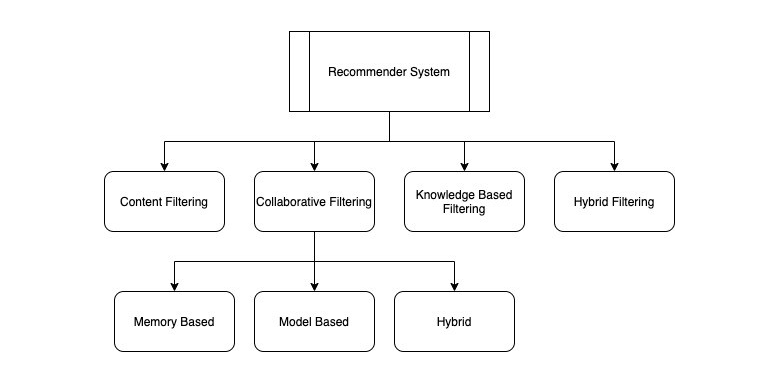

>    Given our dataset has user information, item information and purchase information, we will implement content based filtering method rather than collabarative filtering methon which requires user inputs such as user ratings, comment and many such other data points.

In [ ]:
transaction_data.head(5)

In [ ]:
articles.head(5)

In [ ]:
customers.head(5)

In [ ]:
transaction_profile = ProfileReport(transaction_data, title="Transaction Profiling Report")
transaction_profile

#### EDA

* Trousers is the highest selling product type
* Dress is the second

In [ ]:
fig_prod_type = px.histogram(articles,x='product_type_name')
fig_prod_type.show()

*** Garment Upper body and Garment lower body are the top two product types. There are many with miniscule representation**

In [ ]:
fig_prod_group = px.histogram(articles,y='product_group_name',color='product_type_name')
fig_prod_group.show()

**List the various product types and the count of each under all the product groups. Accessories Product group has the highest number of product types but Trousers under Garment Lower body group has the highest articles**

**Under Departments Jersey  has the highest representation**

In [ ]:
fig_dept_name = px.histogram(articles,y = 'department_name')
fig_dept_name.show()


**Are there any duplicates in articles? No there aren't any**

In [ ]:
articles.shape[0]-articles['article_id'].nunique()

In [ ]:
fig_section_name = px.histogram(articles, y='section_name')
fig_section_name.show()

In [ ]:
fig_colors=px.histogram(articles,y='colour_group_name',color='perceived_colour_value_name')
fig_colors.show()

# Explore Customers

**21 Year olds are the biggest group in the Customers table**

In [ ]:
fig_customers_age= px.histogram(customers,x='age')
fig_customers_age.show()

**There are many whose status is not active**

In [ ]:
customers['Active'].isnull().value_counts(), customers.shape[0]#,customers['Active'].count() 

**Club Member status is mostly Active and very few "LEFT CLUB"**

In [ ]:
fig_cust_club_status = px.histogram(customers,y='club_member_status')
fig_cust_club_status.show()

In [ ]:
fig_fashion_news_freq = px.histogram(customers,y='fashion_news_frequency')
fig_fashion_news_freq.show()

 #### At it's core a recommendation system is as rating system.

 - Now we have to produce the article rating based on the purchase history of the article.
 - This will act as a metric for us to reccomend product to the customer.
 
##### Rating will be given {0,1,2}
The rating will be a cumulative of two individual rating which will be {0,1}
- First rating: If the total article count is  grater than mean article count then 1 else 0

In [ ]:
article_profile = ProfileReport(articles, title="Transaction Profiling Report")
article_profile

In [ ]:
cust_profile = ProfileReport(customers, title="Transaction Profiling Report")
cust_profile

### Content based filtering using Tf-Idf vectorizer and cosine similarity

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
article=pd.read_csv(r"C:\Users\parva\Downloads\H-M-Recommendation-System\articles.csv")
cols=article.columns.tolist()
article.prod_name=article.prod_name.astype('str')
article.detail_desc=article.detail_desc.astype('str')
article.head(5)

In [ ]:
name_corpus=' '.join(article.prod_name)
desc_corpus=' '.join(article.detail_desc)
article['content']=article[['prod_name','detail_desc']].astype('str').apply(lambda x: '//'.join(x),axis=1)
random_article=article.sample(frac=0.1, replace=True, random_state=1)
random_article.content.fillna('Null',inplace=True)

In [ ]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(random_article.content)
tfidf_matrix.shape
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
cols.append('content')
random_article=pd.DataFrame(np.array(random_article),columns=cols)

In [ ]:
result={}
for idx,row in random_article.iterrows():
    
    sim_indices=cosine_sim[idx].argsort()[:-100:-1]
    sim_items=[(cosine_sim[idx][i],random_article['article_id'][i]) for i in sim_indices]
    result[row['article_id']]=sim_items[1:]

In [ ]:
def item(article_id):
    name=random_article.loc[random_article['article_id']==article_id]['content'].tolist()[0].split('//')[0]
    code=random_article.loc[random_article['article_id']==article_id]['product_code']
    # desc   = '\nDescription:'+ random_article.loc[random_article['article_id'] == article_id]['content'].tolist()[0].split(' // ')[1][0:200] + '...'
    prediction=name+str(code)
    return prediction

def recomment(article_id,num):
    
    print("Recommentding:"+str(num)+'similar product to '+item(article_id))
    print('----')
    recs=result[article_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

In [ ]:
recomment(753708001,25)

#### Collaborative based filtering

#### First rating

In [ ]:
#Dataset for first rating
val=pd.DataFrame()
val=(transaction_data.groupby(['article_id']).count()).t_dat
val=pd.DataFrame(val)
val.rename(columns={'t_dat':'count'},inplace=True)
val.reset_index(inplace=True)
val.head(5)

In [ ]:
val_mean=val.mean()[1]
print(f'Mean count of the whole dataset is:{val_mean}')
#Function to assign rating
def first_rate(value):
    if value>val_mean:
        return 1.0
    else:
        return 0.0
val['first_rate']=val['count'].apply(first_rate)
sns.countplot(x='first_rate',data=val,palette='hls')
plt.show()
val.head(5)

#### Second rating

In [ ]:
#Finding the count of article purchased inorder to produce a rating based on its popularity 
rating=pd.DataFrame(transaction_data.groupby(['article_id','customer_id']).count())
rating.reset_index(inplace=True)
rating=rating.drop(columns=['t_dat','sales_channel_id'])
rating.rename(columns={'price':'item_count'},inplace=True)
rating.head()

In [ ]:
test_df=pd.DataFrame(rating.groupby('article_id').mean())
test_df.reset_index(inplace=True)
test_df.head(5)
rating=rating.merge(test_df,on='article_id')
rating.rename(columns={'item_count_x':'customer_count','item_count_y':'customer_mean'},inplace=True)
rating.loc[rating.customer_count>rating.customer_mean,'second_rate']=1
rating.loc[rating.customer_count<rating.customer_mean,'second_rate']=0
rating.head(5)

#### Final rating

- Here we add the first rate and the second rate

In [ ]:
final_rate=rating.merge(val,on='article_id')
final_rate['final_rate']=final_rate.first_rate+final_rate.second_rate
sns.countplot(x='final_rate',data=final_rate,palette='hls')
plt.show()
final_rate.head(5)

In [ ]:
!jupyter labextension install jupyterlab-plotly

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x.customer_count
    R = x.mean_rate
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

#### Popularity With rating 2

In [ ]:
def find_score(article_based):
    article_based=pd.DataFrame(final_rate.groupby('article_id').sum())
    article_based=article_based.drop(columns=['count','customer_mean'])
    article_based.reset_index(inplace=True)
    article_based['mean_rate']=article_based.final_rate/article_based.customer_count
   
    m=article_based.customer_count.quantile(0.9)
    m
    C=article_based.mean_rate.mean()
    C

    q_article=article_based.copy().loc[article_based.customer_count>=m]
    q_article

    # Define a new feature 'score' and calculate its value with `weighted_rating()`
    q_article['score'] = q_article.apply(weighted_rating, axis=1)

    #Sort movies based on score calculated above
    q_article = q_article.sort_values('score', ascending=False)

    #Print the top 15 movies
    print(q_article[['article_id', 'customer_count', 'mean_rate', 'score']].head(10))

In [ ]:
find_score(final_rate.loc[final_rate.final_rate==2])

### Customer Based Approach

In [ ]:
#Customer dataset
#when it comes to customers, the difference in product purchse can be clustered based on age alone.
customers=customers[['customer_id','age']]
bins=[-1,19,29,39,49,59,69,119]
customers['bins']=pd.cut(customers['age'],bins)
customers.head(5)

In [ ]:
working=transaction_data.merge(customers,on='customer_id')
working.head(5)

In [ ]:
#we provide customer_id and hist current cart which is an array of article_id
def recommend(customer_numer,cart):
    #first we identify the purchase history of the given customer
    history_purchase=np.unique(np.array(working.loc[working.customer_id==customer_numer].article_id))
    #list of customers who purchased similar products as purchased by the 
    customer_list=find_customer(history_purchase)
    
    
    
def find_customer(hist):
    cust=[]
    for item in hist:
        customers=working.loc[working.article_id==item and working.].customer_id.to_list()
        cust.extend(customers)
        print(len(cust))
    return cust

In [ ]:
hist=recommend('000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318')